<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/PyTorch-Deep-Learning/blob/master/04-Classic_CNN_Backbones_and_Transfer_Learning.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/PyTorch-Deep-Learning/blob/master/04-Classic_CNN_Backbones_and_Transfer_Learning.ipynb)

# 4. Classic CNN Backbones and Transfer Learning

自從 2012 年 AlexNet 引起新一波人工智慧的熱潮，短短幾年之間，陸續又出現了幾個創新的 CNN 架構。 這些架構優異的物件辨識能力，以及經過 ImageNet 大量資料訓練過的參數，使得這些模型成為後續許多應用用來擷取影像特徵的骨幹。

+ [**4.1 AlexNet**](#alex-net)
    - [*AlexNet model in torchvision*](#alexnet-model)
+ [**4.2 VGG**](#vgg-net)
    - [*VGG model in torchvision*](#vgg-model)
+ [**4.3 ResNet**](#res-net)

+ [**4.4 Inception (GoogLeNet)**](#google-net)

+ [**4.5 DenseNet**](#dense-net)

+ [**參考資料**](#references)


In [1]:
# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image


### § 符號說明

以下說明各經典 CNN 網路的架構，使用符號說明如下：
- $f$: filter，濾波器 kernel 大小，通常用一個整數代表長與寬（大小相等），通道數固定與輸入相同。
- $s$: stride，濾波操作時，尋訪像素的移動間隔。
- $p$: padding，邊緣填充大小，通常也用一個整數代表。


---

<a id="alex-net"></a>

## 4.1 AlexNet

**AlexNet** [[3]](#references) 是 [ILSVRC 2012](https://image-net.org/challenges/LSVRC/2012/) 的獲勝模型，成績達到 top-5 error $15.3 \%$。 ImageNet 資料集的影像大小解析度不一，因此前處理首先統一將輸入資料 down-sampling 為 $256 \times 256$ 的三個 channel 影像，方法是先以最短邊為基準比例調整到$256$，再裁切中間 $256 \times 256$ 的區域。

### § 特點

####  Data Augmentation 資料擴增

資料集越大愈能減少 overfitting，影像資料最常見有效又簡單的手法，就是保持標籤不變對影像進行轉換處理。 AlexNet 在 $256 \times 256$ 大小的影像中，擷取其中隨機 $224 \times 224$ 大小的區域，以及其水平鏡像翻轉的影像，藉此擴大了 2048 倍的訓練集。 測試時也會從輸入 $256 \times 256$ 大小的影像中，分別擷取四個角落和中間 $224 \times 224$ 大小以及其水平鏡像翻轉的區域，總共十個影像取平均預測結果。

#### ReLU

AlexNet 全部使用 **ReLU (Rectified Linear Unit)** activation，據研究指出與傳統的 tanh 或 sigmoid 比起來，使用 ReLU 可以加速訓練的收斂速度，這對使用大型的訓練資料集尤其重要。

#### Dropout

AlexNet 在訓練時，前兩個全連階層的 activation 之後會套用 **Dropout** 的技巧來進一步降低 overfitting。 每個神經元都有 $0.5$ 的機率（超參數）會被丟棄（參數權重設為 $0$），被丟棄的神經元對 forward 或 backward 傳導不會再有任何貢獻，藉此降低網路的複雜度。 注意驗證及測試時不會再套用 隨機 dropout，但會將神經元輸出乘以 $0.5$ 來概略近似 dropout 的預測分布。

#### 其他

原文提及前兩個捲積層在 ReLU 之後 Pooling 之前作了 local Normalization，但後續的研究發現其實並沒有什麼特別效果，因此通常在重現模型的實作時被忽略。 另外，AlexNet 使用了兩個 GPU 進行訓練，作者在另外一篇論文 [[4]](#references) 有較詳盡描述使用多個 GPU 訓練時的幾種方式。


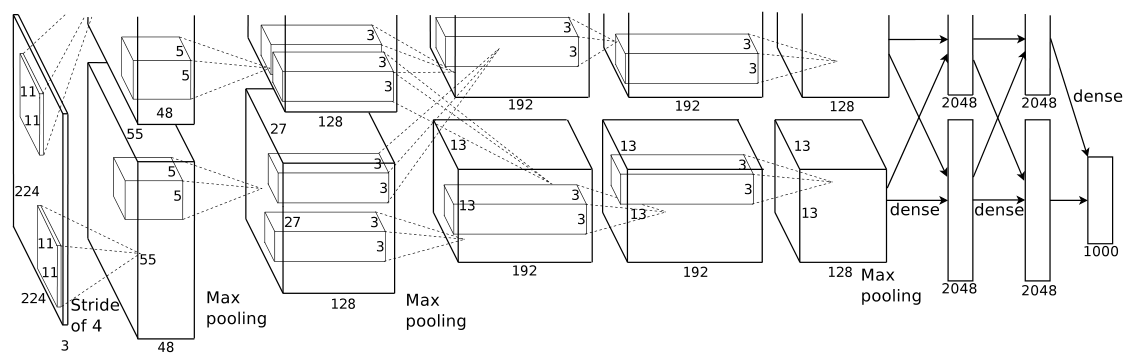

In [4]:
Image(filename='images/alexnet_architecture.png', width=800)

**AlexNet** 是八層的 CNN 網路結構，包含了五個捲積層（**`conv1`**, **`conv2`**, **`conv3`**, **`conv4`**, **`conv5`**），三個全連結層（**`fc1`**, **`fc2`**, **`fc3`**）。

1. **`conv1`**： 輸入影像 $227 \times 227 \times 3$，使用 $96$ 個 kernal，$f=11$，$s=4$，$p=2$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
2. **`conv2`**： 輸入 $27 \times 27 \times 96$，使用 $256$ 個 kernal，$f=5$，$s=1$，$p=2$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
3. **`conv3`**： 輸入 $13 \times 13 \times 256$，使用 $384$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    +
4. **`conv4`**： 輸入 $13 \times 13 \times 384$，使用 $384$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    +
5. **`conv5`**： 輸入 $13 \times 13 \times 384$，使用 $256$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
6. **`fc1`**： 輸入 $6 \times 6 \times 256 = 9216$，輸出數 $4096$。
    + $\to$ *activation*： `relu`
    + $\to$  *dropout*: $0.5$
    +
7. **`fc2`**： 輸入 $4096$，輸出數 $4096$。
    + $\to$ *activation*： `relu`
    + $\to$  *dropout*: $0.5$
    +
8. **`fc3`**： 輸入 $4096$，輸出數 $1000$。
    + $\to$ *activation*： `softmax`


---

<a id="alexnet-model"></a>

### § AlexNet model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 已經包含了經典 AlexNet 的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_alexnet/) 的參數。 以下 AlexNet 模型實作的程式碼僅供參考，實際要使用時直接自 `torchvision.models` import 就可以了。


In [ ]:
# The following AlexNet model code is copied from torchvision.model
# https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
# This model implements the Architecture from paper "One weird trick for parallelizing convolutional neural networks."
import torch
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


---

<a id="vgg-net"></a>

## 4.2 VGG

**VGG** 是 ILSVRC 2014 的獲得第二名的隊伍，命名來自作者所屬實驗室 *Visual Geometry Group*。 VGG 有幾種不同的網路配置，常用的為表格中所列的 *A、B、D、E*（以下介紹忽略 A-LRN 及 C），分別被稱為 ***VGG11***、***VGG13***、***VGG16***、以及 ***VGG19***。

VGG 網路的特點是使用更簡化的架構來嘗試更深的特徵擷取網路，捲積層全部都使用 kernel $3 \times 3$、stride $=1$、 padding $=1$，也固定只用 RelU activation 以及 max pooling $2 \times 2$、stride $=2$。 所以捲積層的輸出的高與寬 $\mathsf{H} \times \mathsf{W}$ 不變，在 pooling 後則減半。


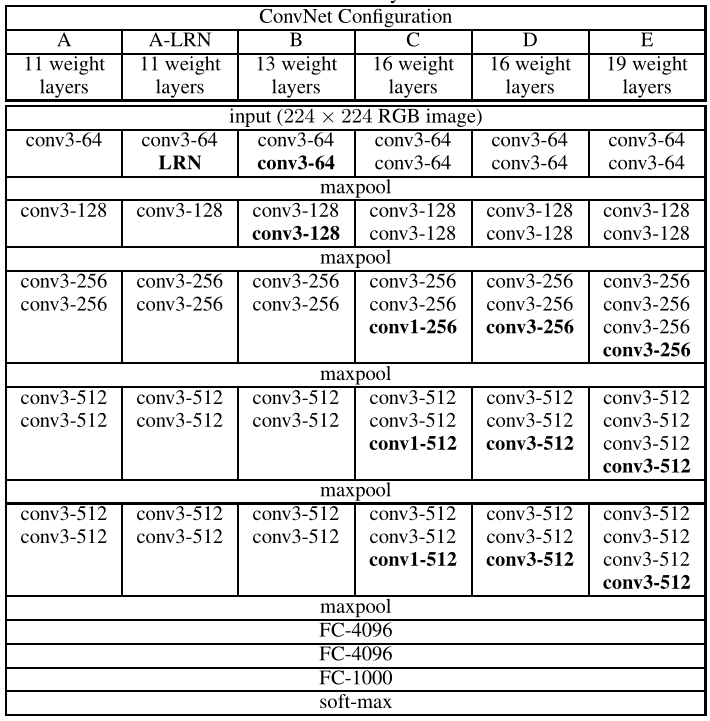

In [6]:
# VGG 原文所列架構配置表
Image(filename='images/vgg_configurations.png', width=450)

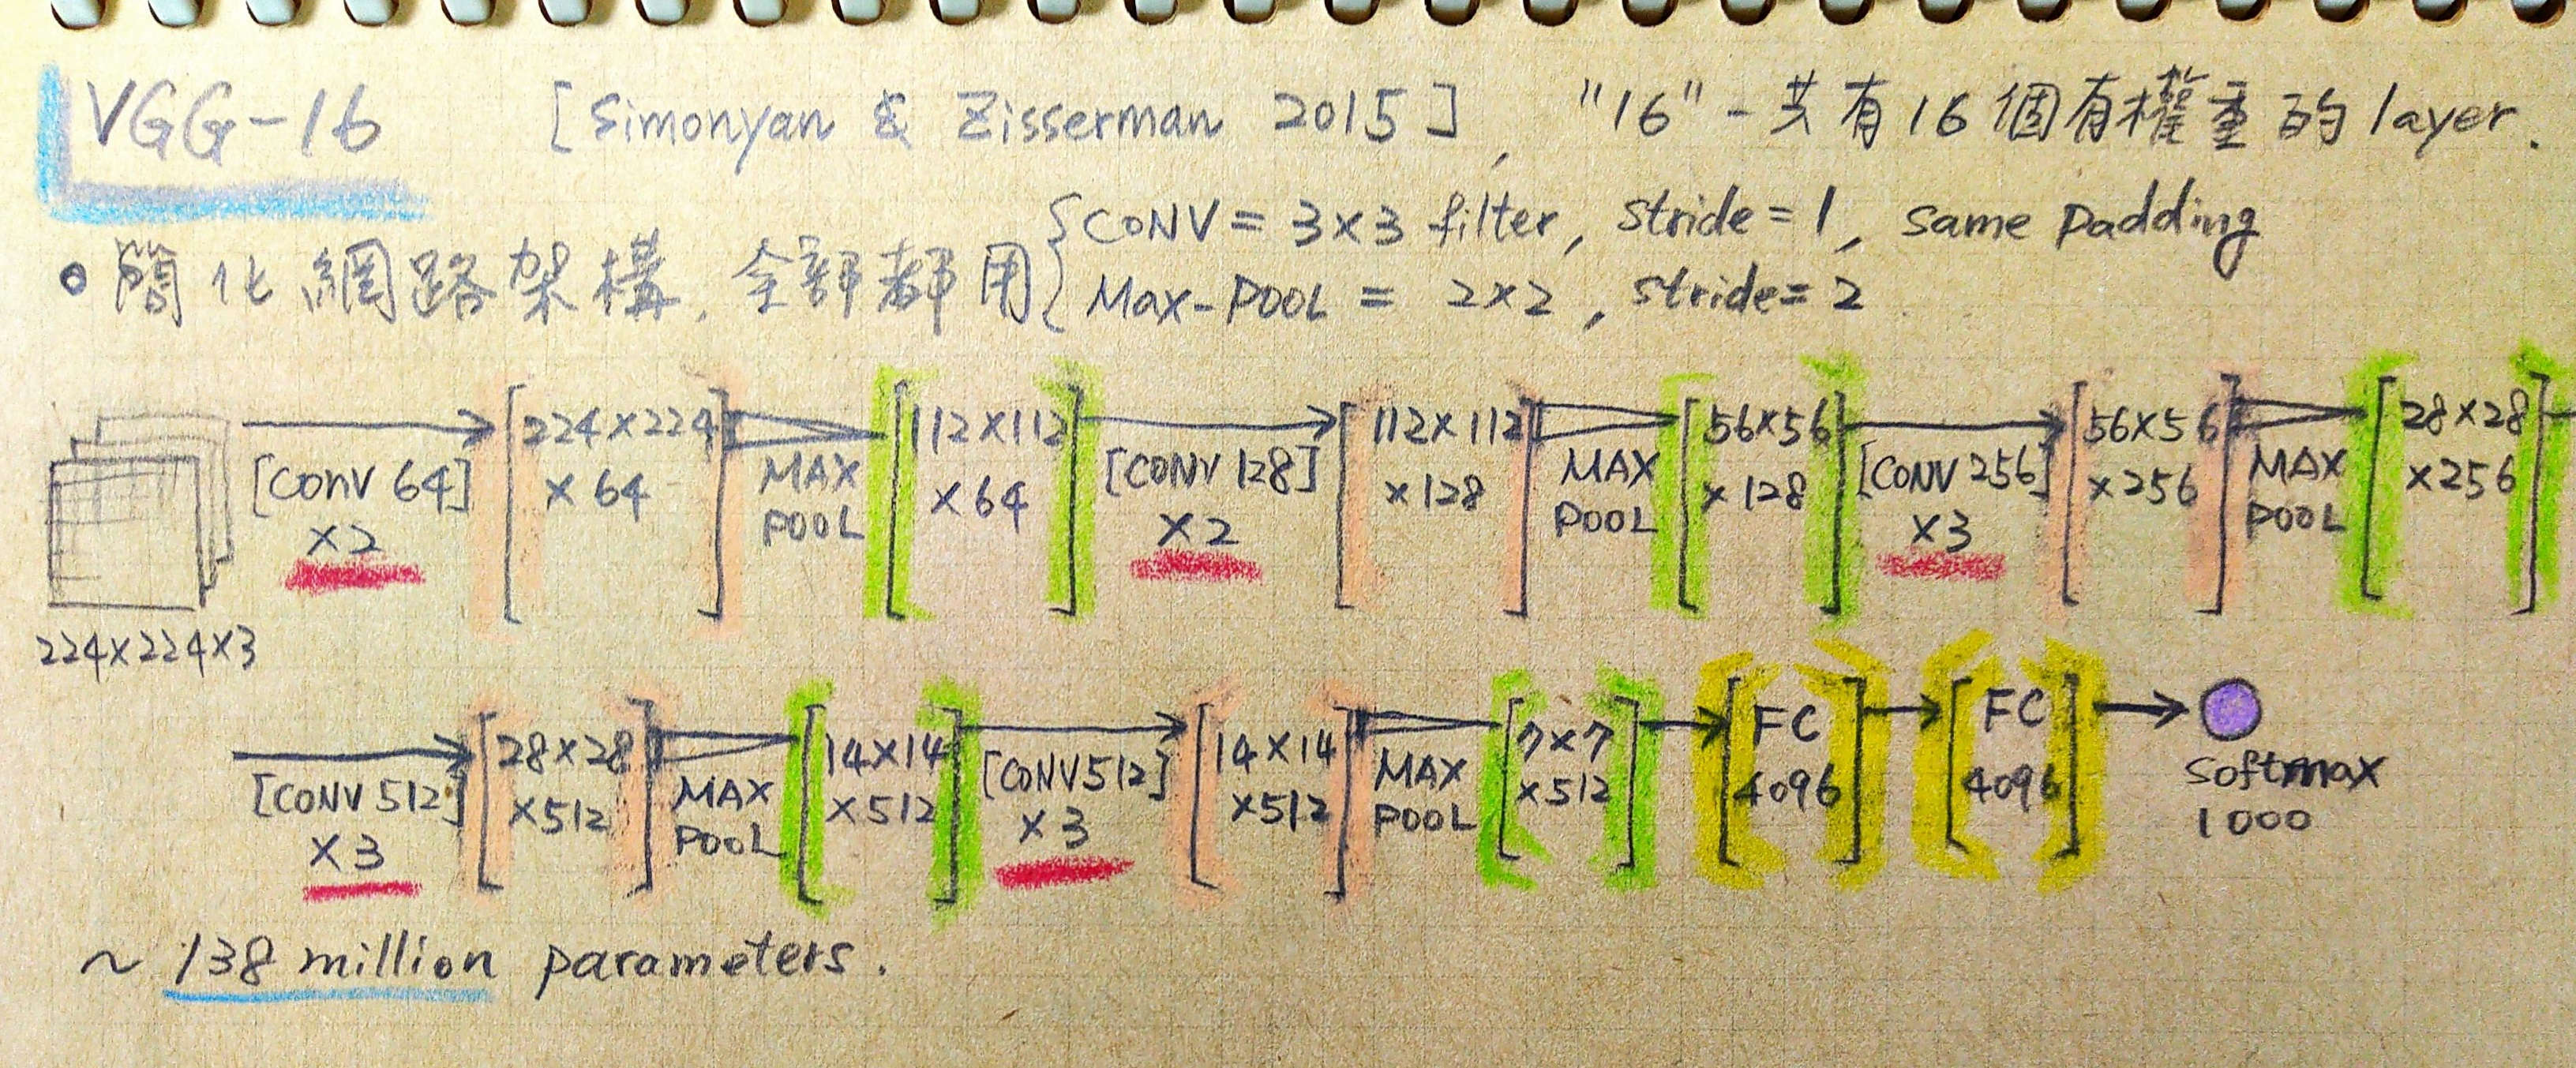

In [2]:
Image(filename='images/vgg16_architecture.jpg', width=800)

---

<a id="vgg-model"></a>

### § VGG model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 中包含了VGG11、VGG13、VGG16、VGG19 的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_vgg/) 的參數。 以下 VGG 模型實作的程式碼僅供參考，實際要使用時直接自 `torchvision.models` import 就可以了。 由於 VGG 重複簡單的架構，所以對於如何定義出架構可參數調整的模型類別，這個實作也是個很好的範例。


In [ ]:
# The following VGG model code is copied from torchvision.model
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
import torch
import torch.nn as nn
from typing import Union, List, Dict, Any, cast

cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 簡化過原程式碼的 vgg16
def vgg16(batch_norm: bool, **kwargs: Any) -> VGG:
    model = VGG(make_layers(cfgs['D'], batch_norm=batch_norm), **kwargs)
    return model


<a id="res-net"></a>

## 4.3 ResNet

**ResNet** 是 ILSVRC 2015 的獲勝模型，該模型首度提出了殘差學習模塊（residual block），藉此成功建構出更深的 CNN 網路。


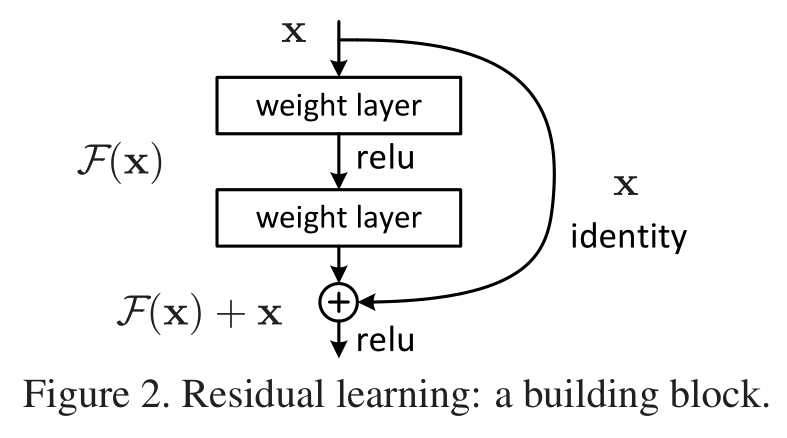

In [8]:
# ResNet 原文所列 residual building block
Image(filename='images/residual_block.png', width=400)

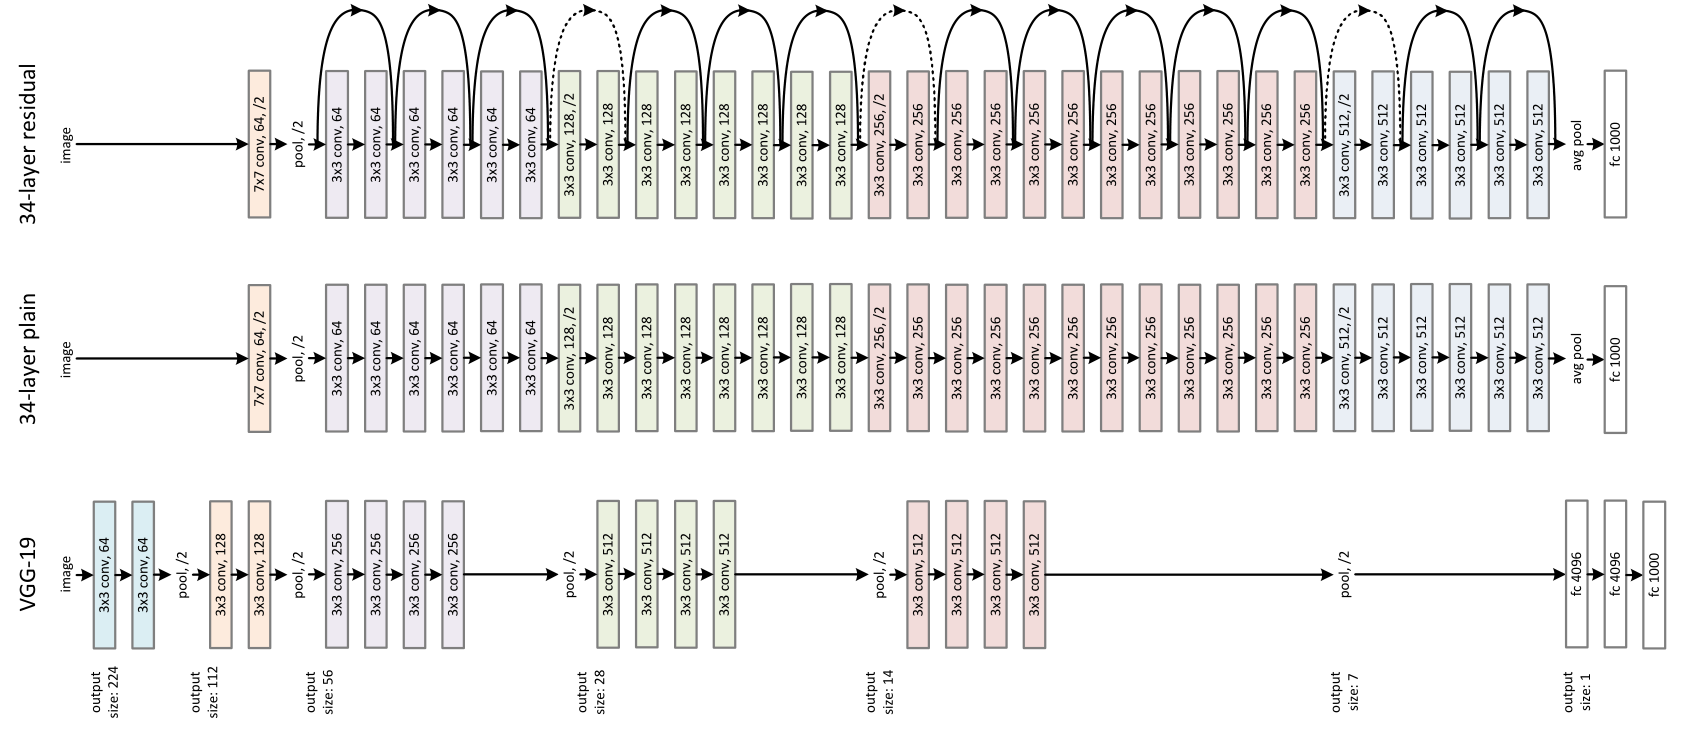

In [12]:
# ResNet 原文架構圖例
Image(filename='images/resnet_architecture.png', width=850)

<a id="google-net"></a>

## 4.4 Inception (GoogLeNet)

(TODO)

<a id="dense-net"></a>

## 4.5 DenseNet

(TODO)

---

<a id="references"></a>

## References:

- [1]. Kevin P. Murphy. "*Probabilistic Machine Learning: An introduction*". MIT press, 2021. [[link]](https://probml.github.io/pml-book/book1.html)
- [2]. Aston Zhang, Zachary Lipton, Mu Li, and Alexander Smola. "*動手學深度學習（PyTorch版）*", 2020. [[link]](https://tangshusen.me/Dive-into-DL-PyTorch)
- [3]. Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. "*Imagenet classification with deep convolutional neural networks.*" In: NIPS, 2012.
- [4]. Alex Krizhevsky, "*One weird trick for parallelizing convolutional neural networks.*" arXiv:1404.5997 (2014).
- [5]. Karen Simonyan, and Andrew Zisserman. "*Very deep convolutional networks for large-scale image recognition.*" arXiv:1409.1556 (2014).
- [6]. Kaiming He, et al. "*Deep residual learning for image recognition.*" In: CVPR, 2016.


---

**June, 2021**

***James Chang***